<a href="https://colab.research.google.com/github/darthfelipe21/ADK_Agent/blob/main/ADKAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


⚙️ Before we get started - Installing Google ADK
Ensure the Google ADK library is installed in your DataLab via pip install google-adk.
Ignore any harmless warnings if the installation completes successfully. ✅

In [ ]:
!pip install protobuf==5.28.1 google-adk==1.0.0 litellm -q -q

In [ ]:
import importlib
importlib.invalidate_caches()


🔐 Configuring API Access
Set your OpenAI API base as an environment variable when using OpenAI models.


In [ ]:
import os
os.environ["OPENAI_API_BASE"]="http://localhost:11434/v1"

🧑‍💻 Creating Our First Agent
Define the agent with:
name: unique identifier for logs,
description: brief internal summary,
instruction: core behavior directive,
model: choose your LLM.
Run the cell to instantiate and test your first ADK agent! 🎉

In [1]:
from google.adk.agents import LlmAgent
from google.adk.models.lite_llm import LiteLlm

AGENT_MODEL = LiteLlm(model="openai/gpt-4o-mini")

agent = LlmAgent(
    name="WelcomeAgent",
    description="An agent that welcomes the user.",
    instruction="always greet the user politely",
    model=AGENT_MODEL
)

print(f"Agent '{agent.name}' created.")

ModuleNotFoundError: No module named 'litellm'


## In the loop: Running our agent

#### 💬 Interacting with the agent
Now that we have our welcome agent defined, the next step is to interact with it.
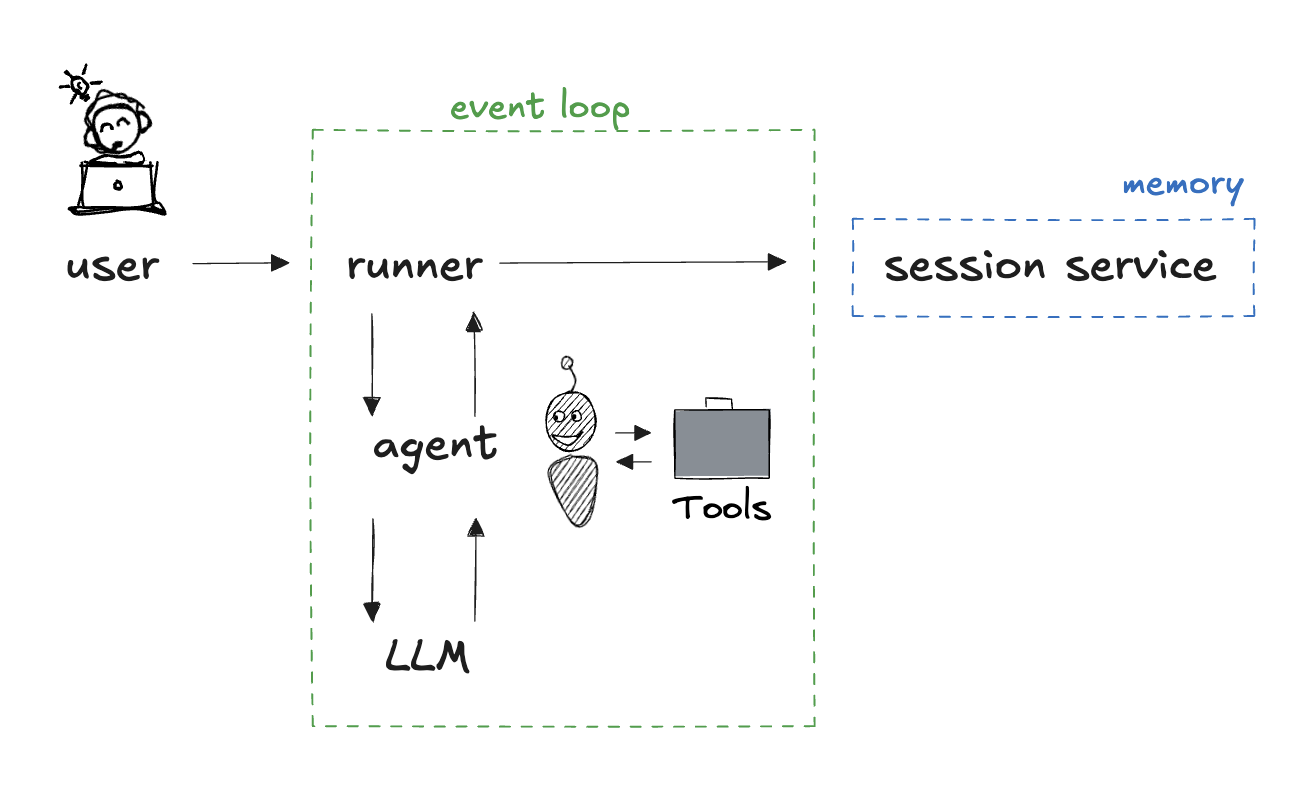![image-3](images/image-3.png)
Let’s unpack the components we need to run our agent:
- **Session Service and Session**: Before the message from the user can be processed, ADK needs to know who is talking and in what context.
- **Runner**: Once the session is in place, the `Runner` orchestrates the agent’s reasoning cycle and manages the flow of the conversation turn.
- **Asynchronous Execution**: Communicating with an LLM API is an operation that can take a bit of time (since it involves network requests).

### ❗️ Note: Run the **hidden cells** below to initialize the agent, before running the rest of the code. ❗️ ``

In [ ]:
# Install and import required libraries
import nest_asyncio
import asyncio
nest_asyncio.apply()  # Required for async in notebooks

from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types

# Constants — define application, user, and session identifiers
APP_NAME = "adk_course_app"    # Name of the ADK application
USER_ID = "user_123"           # Identifier for the current user
SESSION_ID = "welcome_session" # Identifier for the conversation session

In [ ]:
# Define the agent
welcome_agent = LlmAgent(
    name="WelcomeAgent",
    description="An agent that welcomes the user.",
    instruction="Always greet the user politely.",
    model=AGENT_MODEL
)

# Set up session service and create a session
session_service = InMemorySessionService()
await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)

# Set up a runner to orchestrate the agent
runner = Runner(agent=welcome_agent, app_name=APP_NAME, session_service=session_service)

In [ ]:
# Define an asynchronous function to send a query to the agent and handle its response
async def call_agent_async(query: str):
    print(f"\n>>> User Query: {query}")

    # Package the user's query into ADK format
    content = types.Content(role='user', parts=[types.Part(text=query)])
    final_response_text = "Agent did not produce a final response."

    # Iterate through streamed agent responses
    async for event in runner.run_async(user_id=USER_ID, session_id=SESSION_ID, new_message=content):
        if event.is_final_response(): # Check if this is the final message from the agent
            if event.content and event.content.parts:
                final_response_text = event.content.parts[0].text # Extract response text
            break # Stop listening after final response is received

    print(f"<<< Agent Response: {final_response_text}")

# Run the interaction
await call_agent_async("Hi there!")